# Generative Models as Data Augmentation in the Medical Domain

## 1. Overview

This project tries to evaluate the quality of generative models for data augmentation in the medical domain. 

Data augmentation will be relying on geometric data augmentation, (variational) auto-encoder (e.g. stacked denoising, denoising auto-encoder, etc.), and generative adversarial neural networks (e.g. GAN, DCGAN, Wasserstein GAN, etc.) for instance.

We will restrict ourself to three kind of models to generate new data and evaluate the (possible) improvement with regards to a final classification score (i.e. comparing results between augmented and non-augmented training sets). 

### Datasets

We will look into applying the above project on some (if not all) of the following datasets from the MedMNIST Classification Decathlon (https://medmnist.github.io/):

| Dataset | Classification Type | Train size | Validation size | Test size |
| :--- | :--- | :---: | :---: | :---: |  
| PathMNIST Pathology | Multi-Class (9) | 89,996 | 10,004 | 7,180 |
| DermaMNIST Dermatoscope | Multi-Class (7) | 7,007 | 1,003 | 2,005 |
| OCTMNIST OCT | Multi-Class (4) | 97,477 | 10,832 | 1,000 |
| PneumoniaMNIST Chest X-ray | Binary-Class (2) |4,708 | 524 | 624 |
| BreastMNIST Breast Ultrasound | Binary-Class (2) | 546 | 78 | 156 |
| OrganMNIST_Axial Abdominal CT | Multi-Class (11) | 34,581 | 6,491 | 17,778 |
| OragnMNIST_Coronal Abdominal CT | Multi-Class (11) |13,000 | 2,392 | 8,268 |
| OrganMNIST_Sagittal Abdominal CT | Multi-Class (11) | 13,940 | 2,452 | 8,829 |

### Notes

We will also provide a short report (in copy) explaining the choice of VAE, AE, and/or GAN models, outlining differences between datasets' results. We will also try to interprete and justify possible differences with regards to models, data specifications, visual features, and bibliography references used to support the choices made.

## 2. Data and Library Imports

### Source

We will retrieve the above dataset from the following website:

> [MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification](https://medmnist.com/), Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni

By following the instructions on their [github](https://github.com/MedMNIST/MedMNIST), we can download their ready-made module with the following instruction:

```sh
pip install jupyter, ipywidgets, IProgress
pip install medmnist
```

And load it in a python or ipython instance:

```python
import medmnist
```

### Library Imports

In [1]:
from python_scripts.classifier import run_classifier_pipeline
from python_scripts.conditional_vae import run_encoder_pipeline, one_hot
from python_scripts.data import retrieve_flag_info, import_dataset
from python_scripts.data import check_cuda_availability

import warnings
warnings.filterwarnings('ignore')

### Checks CUDA availability

In [2]:
check_cuda_availability()

True,0,<torch.cuda.device object at 0x7f824c2c2a90>,1
NVIDIA GeForce GTX 980 Ti


### Data Imports

In [3]:
data_flags = ["pathmnist", "dermamnist", "octmnist", "pneumoniamnist", 
              "breastmnist", "organamnist", "organcmnist", "organsmnist"]

info_flags = {flag:retrieve_flag_info(flag) for flag in data_flags}

In [ ]:
pathmnist = import_dataset("pathmnist", info_flags)

Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/quentin/.medmnist/dermamnist.npz
Montage of randomly extracted images from the dataset:


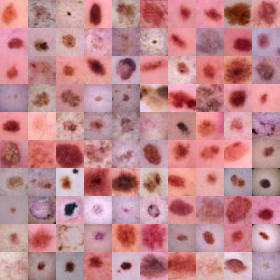

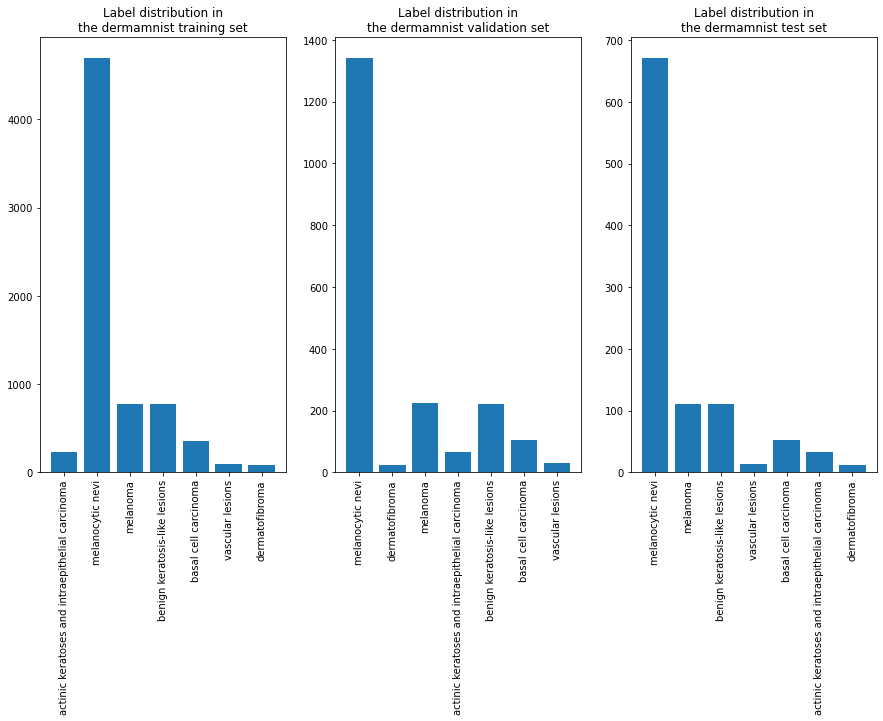

In [4]:
dermamnist = import_dataset("dermamnist", info_flags)

In [ ]:
octmnist = import_dataset("octmnist", info_flags)

In [ ]:
pneumoniamnist = import_dataset("pneumoniamnist", info_flags)

In [ ]:
breastmnist = import_dataset("breastmnist", info_flags)

In [ ]:
organamnist = import_dataset("organamnist", info_flags)

In [ ]:
organcmnist = import_dataset("organcmnist", info_flags)

In [ ]:
organsmnist = import_dataset("organsmnist", info_flags)

## 3. Training a Classifier Without Data Augmentation

### PathMNIST

In [ ]:
clf_pathmnist = run_classifier_pipeline("pathmnist", info_flags, pathmnist)

### DermaMNIST

In [ ]:
clf_dermamnist = run_classifier_pipeline("dermamnist", info_flags, dermamnist)

### OctMNIST

In [ ]:
clf_octmnist = run_classifier_pipeline("octmnist", info_flags, octmnist)

### PneumoniaMNIST

In [ ]:
clf_pneumoniamnist = run_classifier_pipeline("pneumoniamnist", info_flags, pneumoniamnist)

### BreastMNIST

In [ ]:
clf_breastmnist = run_classifier_pipeline("breastmnist", info_flags, breastmnist)

### OrganAMNIST

In [ ]:
clf_organamnist = run_classifier_pipeline("organamnist", info_flags, organamnist)

### OrganCMNIST

In [ ]:
clf_organcmnist = run_classifier_pipeline("organcmnist", info_flags, organcmnist)

### OrganSMNIST

In [ ]:
clf_organsmnist = run_classifier_pipeline("organsmnist", info_flags, organsmnist)

## 4. Training a Conditional Variational Autoencoder for Data Augmentation

### PathMNIST

### DermaMNIST

In [5]:
# Retrieves the dataset parameters
n_classes  = len(info_flags["dermamnist"][0]["label"])
n_channels = info_flags["dermamnist"][0]["n_channels"]

# Declares the number of epochs and the model's latent dimensions
laten_dims = 100
epochs = 200

# Retrieves the data loader
train_loader = dermamnist[3]
val_loader = dermamnist[5]
test_loader = dermamnist[4]

# Runs the conditional VAE
model, training_losses, validation_losses, test_loss = run_encoder_pipeline(
    train_loader, val_loader, test_loader,  
    n_channels, n_classes, laten_dims, epochs, 
    "dermamnist", 
    output_intermediary_info=True
)

Testing Conditional Variational Autoencoder:
Model Output size: torch.Size([10, 3, 28, 28])
Forward pass test:  True
{'loss': tensor(26127.3711, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(26127.3086, grad_fn=<MseLossBackward0>), 'KLD': tensor(-12.3835, grad_fn=<NegBackward0>)}
Loss test:  True
Cuda device:  cuda
Training phase:
Train epoch 1: [0/7007] 	Loss: 632.11676
Train epoch 1: [1280/7007] 	Loss: 131.888824
Train epoch 1: [2560/7007] 	Loss: 83.435028
Train epoch 1: [3840/7007] 	Loss: 85.204796
Train epoch 1: [5120/7007] 	Loss: 75.356346
Train epoch 1: [6400/7007] 	Loss: 60.754112
Train epoch 1 -- average loss: 114.30607847788373
Validation set loss: 85.490312
Train epoch 2: [0/7007] 	Loss: 67.427574
Train epoch 2: [1280/7007] 	Loss: 55.115482
Train epoch 2: [2560/7007] 	Loss: 52.094097
Train epoch 2: [3840/7007] 	Loss: 59.762276
Train epoch 2: [5120/7007] 	Loss: 52.884537
Train epoch 2: [6400/7007] 	Loss: 49.598217
Train epoch 2 -- average loss: 54.32274965547845
Valid

Train epoch 23 -- average loss: 12.231290995555783
Validation set loss: 16.72802
Train epoch 24: [0/7007] 	Loss: 12.944182
Train epoch 24: [1280/7007] 	Loss: 14.273771
Train epoch 24: [2560/7007] 	Loss: 14.280509
Train epoch 24: [3840/7007] 	Loss: 10.256557
Train epoch 24: [5120/7007] 	Loss: 12.93557
Train epoch 24: [6400/7007] 	Loss: 11.226707
Train epoch 24 -- average loss: 11.763685472242601
Validation set loss: 13.141694
Train epoch 25: [0/7007] 	Loss: 10.195864
Train epoch 25: [1280/7007] 	Loss: 13.379319
Train epoch 25: [2560/7007] 	Loss: 10.503256
Train epoch 25: [3840/7007] 	Loss: 11.020556
Train epoch 25: [5120/7007] 	Loss: 12.346483
Train epoch 25: [6400/7007] 	Loss: 10.243827
Train epoch 25 -- average loss: 11.118446094223856
Validation set loss: 12.230697
Train epoch 26: [0/7007] 	Loss: 12.705418
Train epoch 26: [1280/7007] 	Loss: 10.483025
Train epoch 26: [2560/7007] 	Loss: 9.56209
Train epoch 26: [3840/7007] 	Loss: 10.611403
Train epoch 26: [5120/7007] 	Loss: 13.119259
Tr

In [30]:
import torch

n_classes = 7
n_generated_images = 1000

labels = torch.Tensor(np.random.randint(0, n_classes, n_generated_images))
images = model.sample(n_generated_images, 
                      one_hot(labels.int().to(torch.device("cuda")), 
                              n_classes)
                     )

In [40]:
print(labels.shape, images.shape)
print(type(labels), type(images))

torch.Size([1000]) torch.Size([1000, 3, 28, 28])
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [39]:
import torch.utils.data as data_utils

In [43]:
dataset = data_utils.TensorDataset(images, labels)

In [45]:
loader = data_utils.DataLoader(
    dataset,
    batch_size=2
)

In [51]:
next(iter(loader))[0][0].shape

torch.Size([3, 28, 28])

In [54]:
dermamnist[0]

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /home/quentin/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0

In [ ]:
img.detach().cpu().numpy().reshape([3, 28, 28]).T.shape

In [ ]:

def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(0.5, 0.5))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)
    
show_images([img.detach().cpu().numpy().reshape([3, 28, 28]).T])

In [26]:
import numpy as np
np.random.randint(0, 7, 10)

array([2, 5, 6, 1, 6, 0, 5, 1, 3, 2])

### OctMNIST

### PneumoniaMNIST

### BreastMNIST

### OrganAMNIST

### OrganCMNIST

### OrganSMNIST